In [15]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../../')
import do_mpc
import pandas as pd

In [89]:
res = do_mpc.data.load_results('./results/001_kite.pkl')

phi = res['simulator']['_x', 'phi'].flatten()
theta = res['simulator']['_x', 'theta'].flatten()
u_tilde = res['simulator']['_u', 'u_tilde'].flatten()
psi = res['simulator']['_x', 'psi'].flatten()
E_0 = res['simulator']['_p', 'E_0'].flatten()
v_0 = res['simulator']['_p', 'v_0'].flatten()


nn_input = {'phi':phi, 'theta': theta, 'u_tilde': u_tilde}
nn_output = {'phi':phi, 'theta': theta, 'psi': psi,  'u_tilde': u_tilde, 'E_0': E_0, 'v_0': v_0}

nn_input_df = pd.DataFrame.from_dict(nn_input)
nn_output_df = pd.DataFrame.from_dict(nn_output)

nn_input_list = [nn_input_df]
nn_output_list = [nn_output_df]

## RNN I/O structure
All our recurrent neural networks are trained with the stateful setting **True**. The settings is explained [here](https://keras.io/examples/lstm_stateful/). In summary, after having trained on a given data sequence, we use the resulting hidden state to initialize the next sequence. This is beneficial, when a very long coherent sequence is chopped into chunks for training (due to memory restrictions). In practice this allows to train the network to incoroporate much older information than the horizon, as defined with `seq_length`, contains. 

The downside of stateful training is, that data pre-processing is becoming more complex, when using batches. 
In the code cell below, we are preparing the data for stateful training with `batch_size > 0`.

In [39]:
n_datasets = len(nn_input_list)
seq_length = 30  # length of sequence for ANN training

n_data = nn_input_list[0].shape[0]
n_seq = n_data // seq_length - 1

# create sequences from the data:
X = []
Y = []
for data_i in range(n_datasets):
    X_train = nn_input_list[data_i].to_numpy()
    Y_train = nn_output_list[data_i].to_numpy()
    for offset in range(n_seq):
        for data_sample in range(n_seq-1):
            start_ind = data_sample*seq_length+offset
            X.append(X_train[start_ind:start_ind + seq_length, :])
            Y.append(Y_train[start_ind:start_ind + seq_length, :])

X = np.stack(X, axis=0)  # [m, seq_length, nx]
Y = np.stack(Y, axis=0)  # [m, seq_length, ny]

batch_size = n_seq*n_datasets
nx = X.shape[2]
ny = Y.shape[2]

We obtain the following training data shape:

In [42]:
X.shape

(2352, 30, 3)

Note that with the batch_size:

In [43]:
batch_size

49

WE obtain

In [44]:
X.shape[0]/batch_size

48.0

consecutive sequences for each batch.

# Create RNN:

In [46]:
def get_model(model_param, nx, ny, batch_size, seq_length, stateful=True, return_sequences=True):
    n_a = model_param['RNN_param']['n_activation']

    implementation_mode = model_param['RNN_param']['implementation']

    model = keras.models.Sequential()
    if 'SimpleRNN' in model_param['RNN_param']['RNN_type']:
        model.add(keras.layers.SimpleRNN(n_a, input_shape=(seq_length, nx), batch_size=batch_size,
                                         return_sequences=return_sequences, stateful=stateful))
    elif 'GRU' in model_param['RNN_param']['RNN_type']:
        model.add(keras.layers.GRU(n_a, input_shape=(seq_length, nx), recurrent_activation='sigmoid', batch_size=batch_size,
                                   return_sequences=return_sequences, stateful=stateful, implementation=implementation_mode))
    elif 'LSTM' in model_param['RNN_param']['RNN_type']:
        model.add(keras.layers.LSTM(n_a, input_shape=(seq_length, nx), recurrent_activation='sigmoid', batch_size=batch_size,
                                    return_sequences=return_sequences, stateful=stateful, implementation=implementation_mode))

    for units, activation in zip(model_param['n_units'], model_param['activation']):
        model.add(keras.layers.TimeDistributed(keras.layers.Dense(units, activation=activation)))
    model.add(keras.layers.TimeDistributed(keras.layers.Dense(ny, activation='linear')))
    return model

In [47]:
stateful = True
n_layer = 2  # hidden layer - output layer (linear) is automatically added
model_param = {}
model_param['RNN_param'] = {}
model_param['n_units'] = (n_layer) * [40]
model_param['p_dropout'] = None  # Placeholder. Not yet used.
model_param['activation'] = (n_layer) * ['tanh']

model_param['RNN_param']['RNN_type'] = 'LSTM'
model_param['RNN_param']['n_activation'] = 40
model_param['RNN_param']['recurrent_dropout'] = 0
model_param['RNN_param']['dropout'] = 0.
model_param['RNN_param']['implementation'] = 2

model = get_model(model_param, nx, ny, batch_size=batch_size,
                  seq_length=seq_length, stateful=stateful)

model.compile(loss='mse', optimizer='Adam')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (49, 30, 40)              7040      
_________________________________________________________________
time_distributed (TimeDistri (49, 30, 40)              1640      
_________________________________________________________________
time_distributed_1 (TimeDist (49, 30, 40)              1640      
_________________________________________________________________
time_distributed_2 (TimeDist (49, 30, 6)               246       
Total params: 10,566
Trainable params: 10,566
Non-trainable params: 0
_________________________________________________________________


In [50]:
cb_reset = keras.callbacks.LambdaCallback(on_epoch_end=model.reset_states())

model.fit(X, Y, callbacks=[cb_reset], batch_size=batch_size,
          epochs=50, verbose=1, shuffle=not(stateful))

Train on 2352 samples
Epoch 1/50
2352/2352 [==============================] - 1s 256us/sample - loss: 0.0669
Epoch 2/50
2352/2352 [==============================] - 1s 237us/sample - loss: 0.0055
Epoch 3/50
2352/2352 [==============================] - 1s 234us/sample - loss: 0.0043
Epoch 4/50
2352/2352 [==============================] - 1s 226us/sample - loss: 0.0039
Epoch 5/50
2352/2352 [==============================] - 1s 231us/sample - loss: 0.0030
Epoch 6/50
2352/2352 [==============================] - 1s 249us/sample - loss: 0.0028
Epoch 7/50
2352/2352 [==============================] - 1s 235us/sample - loss: 0.0027
Epoch 8/50
2352/2352 [==============================] - 1s 238us/sample - loss: 0.0026
Epoch 9/50
2352/2352 [==============================] - 1s 239us/sample - loss: 0.0025
Epoch 10/50
2352/2352 [==============================] - 1s 245us/sample - loss: 0.0024
Epoch 11/50
2352/2352 [==============================] - 1s 238us/sample - loss: 0.0024
Epoch 12/50
2352/23

# Evaluate Model
To evaluate the model, we create a similar structure but with `seq_length=1` and `batch_size=1`. The weights are taken from the trained model. This model can be evaluated recursiveley (with a single sequence element as input) and keeps track of the hidden state itself.

In [51]:
model_simple = get_model(model_param, nx, ny, batch_size=1,
                         seq_length=1, stateful=stateful)

model_simple.set_weights(model.get_weights())

model_simple.summary()
model_simple.reset_states()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (1, 1, 40)                7040      
_________________________________________________________________
time_distributed_3 (TimeDist (1, 1, 40)                1640      
_________________________________________________________________
time_distributed_4 (TimeDist (1, 1, 40)                1640      
_________________________________________________________________
time_distributed_5 (TimeDist (1, 1, 6)                 246       
Total params: 10,566
Trainable params: 10,566
Non-trainable params: 0
_________________________________________________________________


In [90]:
model_simple.reset_states()
test_with = 0
nn_input_test = nn_input_list[test_with]


res = []

for i,in_i in nn_input_test.iterrows():
    rnn_in = in_i.to_numpy().reshape(1,-1)
    rnn_out = model_simple.predict(rnn_in.reshape(1,1,-1))
    res.append(rnn_out)
res = np.concatenate(res, axis=0).squeeze()

In [91]:
res_df = pd.DataFrame(res, columns = nn_output.keys())

Text(0, 0.5, 'v_0')

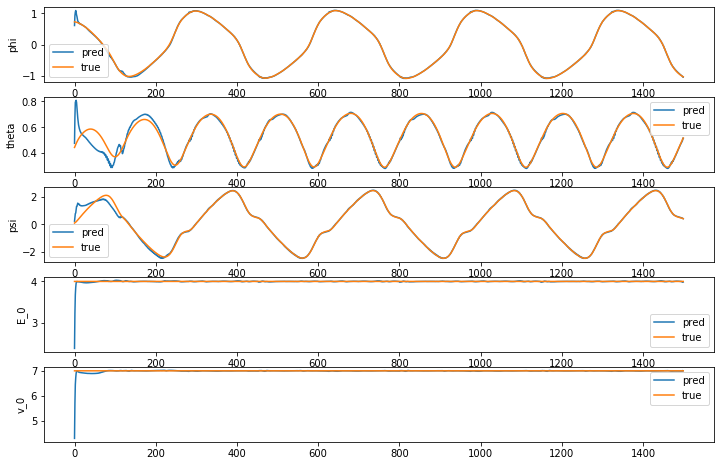

In [92]:
fig, ax = plt.subplots(5, figsize=(12,8))

res_df.plot(y=['phi'], ax=ax[0], label=['pred'])
nn_output_df.plot(y=['phi'], ax=ax[0], label=['true'])
ax[0].set_ylabel('phi')

res_df.plot(y=['theta'], ax=ax[1], label=['pred'])
nn_output_df.plot(y=['theta'], ax=ax[1], label=['true'])
ax[1].set_ylabel('theta')

res_df.plot(y=['psi'], ax=ax[2], label=['pred'])
nn_output_df.plot(y=['psi'], ax=ax[2], label=['true'])
ax[2].set_ylabel('psi')

res_df.plot(y=['E_0'], ax=ax[3], label=['pred'])
nn_output_df.plot(y=['E_0'], ax=ax[3], label=['true'])
ax[3].set_ylabel('E_0')

res_df.plot(y=['v_0'], ax=ax[4], label=['pred'])
nn_output_df.plot(y=['v_0'], ax=ax[4], label=['true'])
ax[4].set_ylabel('v_0')